### Multilayer Perceptron (MLP) for binary classification

1. A multilayer perceptron is a stack of fully connected (FC) layers
2. Binary classification indicates the output can be treated as a coin toss(Yes/No or ClassA/ClassB)

This notebook provides handlers to generate MLP models with varying number of hidden layers and nodes per layer using scikit-learn

Workflow and details
===========================

1. Load software dependencies (Python modules)

2. Load data to Python as an AnnData object (from a loomfile)

3. **Define a model** -> Specify architecture i.e. how many layers, how many nodes, activation functions, etc
4. **Compile a model** -> Provide a loss function, an optimizer and optionally performance metrics
  * The loss function is the mathematical expression that evaluates the error i.e. the difference between truth and prediction.
  The loss function depends on the prediction task. It's not the same if the model is performing regression, classification, etc. And even within classification (like this case) several losses could be used
  
  * The optimizer is the algorithm that given a loss (i.e. the output of the loss _function_) updates the weights (parameters) of the model in order to decrease said loss in the next training iteration. This can be done in different ways,
  but most algorithms consist of a variation of Stochastic Gradient Descent (SGD) and the standard backpropagation algorithm.
  
  * A performance metric quantifies in some way how well the model is doing. The loss is a performance metric itself, but it's hard to interpret in absolute terms.
  For a classification task, the accuracy is one possible metric to look at (just % predictions are correct).
    

5. **Train a model** -> Specify more details about how the training should happen (batch size, number of epochs, ...) and actually expose the model to the data and make it "learn"

  * Batch size is the number of datapoints (fly brain cells in this case) that are passed through the network before the loss is updated. Each new value of the loss is computed on `batch_size` number of cells.
  A default and common batch size is 32.
  One could take the whole dataset as a batch, but that would take painfully long (it would have to give a prediction for ALL cells and then compute the loss) and the obtained loss is probably gonna be very similar to the loss obtained on a small sample (batch). One could also use a batch of 1, which is as fast as it can get, but then it can be very noisy. 32 is a nice value because it's a nice compromise between robust and efficient loss computations.
  
  * One epoch is fulfilled when the model has seen each datapoint (brain cell) once. This can happen in any number of iterations. If the batch size is equal to the size of the dataset, one iteration is one epoch. If the batch size is 1, then a number of iterations equal to the size of the dataset is needed for an epoch to be completed. If the batch size is 32, then we need `(dataset_size / 32 + 1)` iterations.
  
  
  
  

### Load software

In [11]:
import sys
import os.path
import time
import logging
from tqdm import tqdm_notebook as tqdm
from typing import List, Tuple, Union, Dict
import random
import pickle


In [12]:
import h5py
import anndata
import scanpy as sc
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,7) # make plots big

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

Display the software versions, for reproducibility

* `Python`
* `scanpy`
* `loompy`
* `anndata`

are highly susceptible to change their behavior significantly, thus this notebook is actually unlikely to work unless your versions match exactly to those listed below

If it works, even with different versions, it either is a miracle or you don't get an error but the results are wrong!!

The right version of this packages is available on cv1 in the `TF` conda environment / kernel
You can select this environment by going to the top right corner and selecting the kernel called `TF`

Please note. Tensorflow has system dependencies to work with the GPU. More concretely it needs the right CUDA, cuDNN and friends. So checking the tensorflow version is not enough if you want to run the GPU.
Make sure the right CUDA, cuDNN, etc (right meaning compatible with tensorflow 2.1.0) is available in your system. It is on cv1.

In [14]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
loompy    : 3.0.6
numpy     : 1.19.5
anndata   : 0.7.5
logging   : 0.5.1.2
sys       : 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
scanpy    : 1.6.0
pandas    : 1.2.0
h5py      : 2.10.0
matplotlib: 3.1.3



In [37]:
class MLModel:
    
    def __init__(self, adata, target):
        self.adata = adata
        self.adata.obs["CellID"] = self.adata.obs.index.values
        self.adata_with_filters = self.adata
        
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        
        self.train_indices = None
        self.test_indices = None

        self.target = target


    def filter_data(self, filters):
        """
        Given a list of filters return the adata composed by the cells matching all filters
        A single filter is an iterable of length 2, where
        * the first element is a column in obs
        * the second element is an iterable with the accepted values for that column
        example: ['Condition', ['ZT 20 sleep']]
        a list of filters as passed to this method would then look like:
        [['Condition', ['ZT 20 sleep']]]
        
        """
        adata = self.adata.copy()
        for f in filters:
            adata = adata[adata.obs[f[0]].isin(f[1])]
            
        self.adata_with_filters = adata
        

    
    def train_test_split(self, *args, random_state=1,**kwargs):
        """
        Split the dataset into training and test sets, stratify using the target
        """
        
        X=self.adata_with_filters.X
        Y=self.adata_with_filters.obs[self.target]
        X=pd.DataFrame(X)
        Y=pd.Series(Y)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, *args, stratify=Y, random_state=random_state, **kwargs
        )
        
        self.x_train = X_train
        self.y_train = y_train
        self.x_test = X_test
        self.y_test = y_test

        self.train_indices = X_train.index
        self.test_indices = X_test.index
        
        self.mlp = None
            
     
        print("Training dataset: %d cells x %d genes" % self.x_train.shape) # n cells x n genes
        print("Testing dataset: %d cells x %d genes" % self.x_test.shape) # n cells x n genes
        
        print("Fraction of sleep cells in train dataset: %2.3f" % np.array("Sleep" == self.obs_train["Treatment"].values, dtype=np.uint8).mean())
        print("Fraction of wake cells in train dataset: %2.3f" % np.array("Wake" == self.obs_train["Treatment"].values, dtype=np.uint8).mean())
         
        print("Fraction of sleep cells in test dataset: %2.3f" % np.array("Sleep" == self.obs_test["Treatment"].values, dtype=np.uint8).mean())
        print("Fraction of wake cells in test dataset: %2.3f" % np.array("Wake" == self.obs_test["Treatment"].values, dtype=np.uint8).mean())   
        
        
    @property
    def umap_train(self):
        
        self._umap_train = np.array(self.adata_with_filters.obsm["X_umap"][self.train_indices,])
        return self._umap_train            
    
    @property
    def obs_train(self):
        self._obs_train = self.adata_with_filters.obs.iloc[self.train_indices,]
        return self._obs_train

    
    @property
    def umap_test(self):
        self._umap_test = np.array(self.adata_with_filters.obsm["X_umap"][self.test_indices,])
        return self._umap_test
    
    @property
    def obs_test(self):
        self._obs_test = self.adata_with_filters.obs.iloc[self.test_indices,]
        return self._obs_test
    
    
    def cell_counts(dataset_name, groupby):
        
        if dataset_name == "train":
            dataset = self.obs_train
        elif dataset_name == "test":
            dataset = self.obs_test    
        else:
            return
        
        return dataset[[groupby, "CellID"]].groupby(groupby).count()
        
        
    def make_mlp(self, *args, random_state=1,  max_iter=1000, **kwargs):
        self.mlp = MLPClassifier(*args, random_state=random_state, max_iter=max_iter, **kwargs)
    
    def train_mlp(self):
        self.mlp.fit(self.x_train, self.y_train)
        
    def predict(self, x):
        predictions = self.mlp.predict(x)
        return predictions
    
    
    def score(self, x, y):
        score = self.mlp.score(x, y)
        return score
        
        

In [38]:
h5ad_files = [os.path.join("../data/h5ad/Preloom/", e) for e in os.listdir("../data/h5ad/Preloom/")  if e.split(".")[1] == "h5ad"]
h5ad_files.pop(2)
targets = ["Treatment", "Genotype", "Run"]
models = []
h5ad_files

['../data/h5ad/Preloom/Ensheathing_Glia_No_ZT2_Wake.h5ad',
 '../data/h5ad/Preloom/a_b_prime_KCs_No_ZT2_Wake.h5ad',
 '../data/h5ad/Preloom/Surface_Glia_No_ZT2_Wake.h5ad',
 '../data/h5ad/Preloom/y_KCs_No_ZT2_Wake.h5ad',
 '../data/h5ad/Preloom/Astrocytes_No_ZT2_Wake.h5ad',
 '../data/h5ad/Preloom/a_b_KCs_No_ZT2_Wake.h5ad']

In [40]:
arch = (500, 250, 50,)
scores_file = "../results/" + "-".join([str(e) for e in arch]) + "_scores.txt"

In [41]:
if not os.path.exists(scores_file):
    with open(scores_file, "w") as fh:        
        fh.write("cluster,target,score\n")


In [42]:
scores=pd.read_csv(scores_file)
scores

,cluster,target,score
0,../data/h5ad/Preloom/Ensheathing_Glia_No_ZT2_W...,Treatment,0.552381
1,../data/h5ad/Preloom/Ensheathing_Glia_No_ZT2_W...,Genotype,0.733333
2,../data/h5ad/Preloom/Ensheathing_Glia_No_ZT2_W...,Run,0.809524
3,../data/h5ad/Preloom/a_b_prime_KCs_No_ZT2_Wake...,Treatment,0.727273
4,../data/h5ad/Preloom/a_b_prime_KCs_No_ZT2_Wake...,Genotype,0.927273
5,../data/h5ad/Preloom/a_b_prime_KCs_No_ZT2_Wake...,Run,0.818182
6,../data/h5ad/Preloom/Surface_Glia_No_ZT2_Wake....,Treatment,0.525000
7,../data/h5ad/Preloom/Surface_Glia_No_ZT2_Wake....,Genotype,0.850000
8,../data/h5ad/Preloom/Surface_Glia_No_ZT2_Wake....,Run,0.825000
9,../data/h5ad/Preloom/y_KCs_No_ZT2_Wake.h5ad,Treatment,0.689024


In [44]:
done_already = [f"{x['cluster']} - {x['target']}" for _, x in scores.iterrows()]

In [25]:
for f in h5ad_files:
    print(f)
    adata = anndata.read_h5ad(f)
    for t in targets:
        
        if f"{f} - {t}" in done_already:
            continue
            
        model = MLModel(adata=adata.copy(), target=t)
        model.filter_data(
            [
            ["Condition", ["ZT 20 sleep", "ZT 20 sleep deprivation"]],
            ["Genotype", ["line_303", "line_88"]]
            ]
        
        )
        model.train_test_split()
        model.make_mlp(hidden_layer_sizes=arch)
        model.train_mlp()
        score = model.score(model.x_test, model.y_test)
#         scores[f][t] = score
        with open(scores_file, "a") as fh:
            fh.write(f"{f},{t},{score}\n")        

In [72]:
adata = anndata.read_h5ad("../data/h5ad/Preloom/y_KCs_No_ZT2_Wake.h5ad")
adata

/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 4412 × 1320
    obs: 'Age', 'Condition', 'Genotype', 'Run', 'Singlet', 'Sleep_Stage', 'Treatment', 'doublet_scores', 'n_counts', 'n_genes', 'percent_mito', 'predicted_doublets', 'louvain', 'louvain_res0.4', 'louvain_res0.8', 'louvain_res1.0', 'louvain_res1.2', 'louvain_res1.6', 'louvain_res2.0', 'louvain_res3.0', 'louvain_res4.0', 'louvain_res8.0', 'Run_Set'
    var: 'gene_ids', 'feature_types', 'n_cells-20180419', 'n_cells-20191009', 'n_cells-20191023', 'n_cells-20191106', 'n_cells-20200902', 'n_cells-20200916', 'n_cells-20200924', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Age_colors', 'Condition_colors', 'Genotype_colors', 'Run_Set_colors', 'Run_colors', 'Sleep_Stage_colors', 'Treatment_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_louvain_res0.4', 'rank_genes_groups_louvain_res0.8', 'rank_genes_groups_louvain_res1.0', 'rank_genes_groups_louvain_res1.2', 'rank_genes_

In [45]:
model = MLModel(adata=adata, target="Treatment")
model.filter_data(
    [
    ["Condition", ["ZT 20 sleep", "ZT 20 sleep deprivation"]],
    ["Genotype", ["line_303", "line_88"]]
    ]

)
model.train_test_split()
model.make_mlp(hidden_layer_sizes=(200, 100,10,))
model.train_mlp()
score = model.score(model.x_test, model.y_test)


/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Training dataset: 492 cells x 1320 genes
Testing dataset: 164 cells x 1320 genes
Fraction of sleep cells in train dataset: 0.467
Fraction of wake cells in train dataset: 0.533
Fraction of sleep cells in test dataset: 0.463
Fraction of wake cells in test dataset: 0.537


In [46]:
predictions = model.predict(model.x_test)

In [49]:
# model._obs_test

In [28]:
# weights = model.mlp.coefs_[0]
# wn = weights - weights.min()
# wn = 255 * wn / wn.max()
# wn=np.array(wn, dtype=np.uint8)
# plt.hist(wn.mean(axis=1), bins=30)
# gene_weight = wn.mean(axis=1)
# plt.imshow(wn, cmap="gray")

In [55]:
obs_test = model.obs_test
obs_test["Correct_Prediction"] = np.array(predictions == model.obs_test[model.target].values, dtype=np.uint8)

/home/vibflysleep/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
obs_test["Correct_Prediction"].mean()

0.6951219512195121

In [59]:
obs_test[["Treatment", "Genotype", "Run", "Correct_Prediction"]].groupby(["Treatment", "Genotype"]).mean()

Correct_Prediction
Treatment Genotype                    
Sleep     line_88             0.235294
          line_303            0.796610
Wake      line_88             0.774648
          line_303            0.470588

In [60]:
obs_test[["Treatment", "Genotype", "Run", "Correct_Prediction"]].groupby(["Treatment", "Run"]).mean() * 100

Correct_Prediction
Treatment Run                         
Sleep     20191009           79.661017
          20200902           23.529412
Wake      20191009           77.464789
          20200902           47.058824

In [68]:
markers = {True: "*", False: "x"}
colors = {"Sleep": "blue", "Wake": "red"}

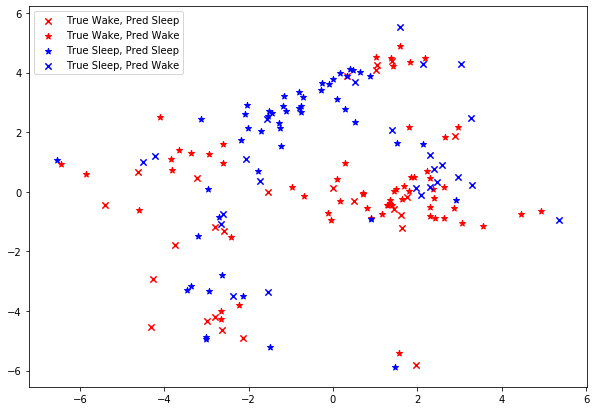

In [71]:
plt.rcParams["figure.figsize"] = (10,7) # make plots big

for treatm in model.obs_test["Treatment"].unique():
    for pred in np.unique(predictions):
        m = markers[treatm==pred]
        subset = model.umap_test[np.bitwise_and(model.obs_test["Treatment"] == treatm, predictions == pred),:]
        x = subset[:,0]
        y = subset[:,1]        
        plt.scatter(x, y, label = f"True {treatm}, Pred {pred}",marker=m, c=colors[treatm], s=40)
        
plt.legend()
plt.savefig("../results/plots/2021-07-15_umap_predictions.png")

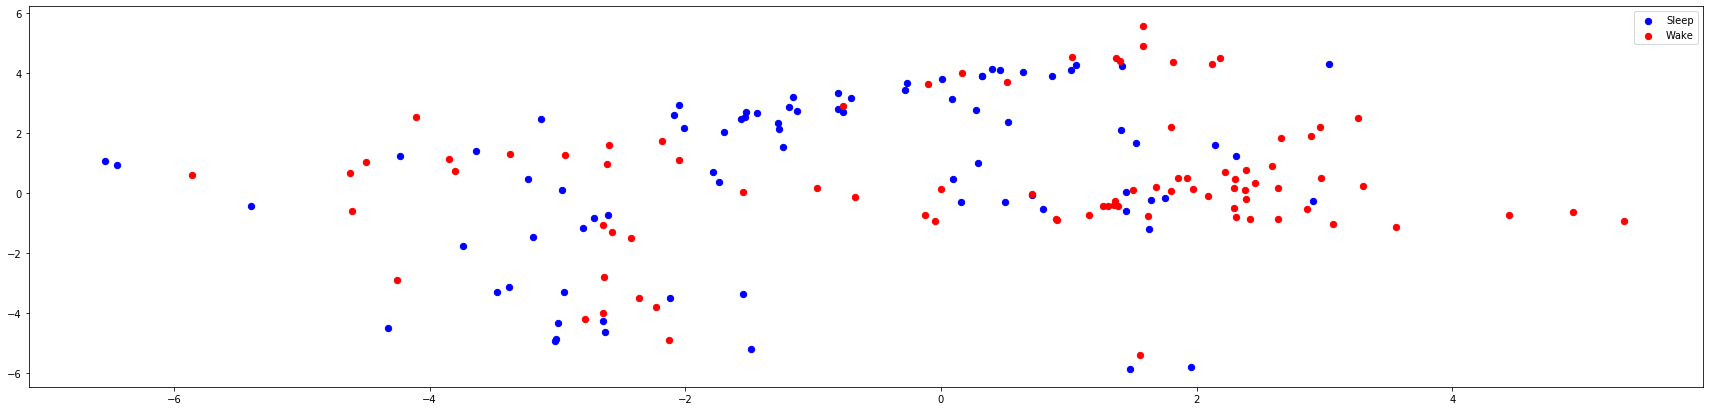

In [382]:
for pred in np.unique(predictions):
    subset = umap_test[predictions == pred,:]
    x = subset[:,0]
    y = subset[:,1]        
    plt.scatter(x, y, label = f"{pred}",
                c=colors[pred], s=40)
        
plt.legend()

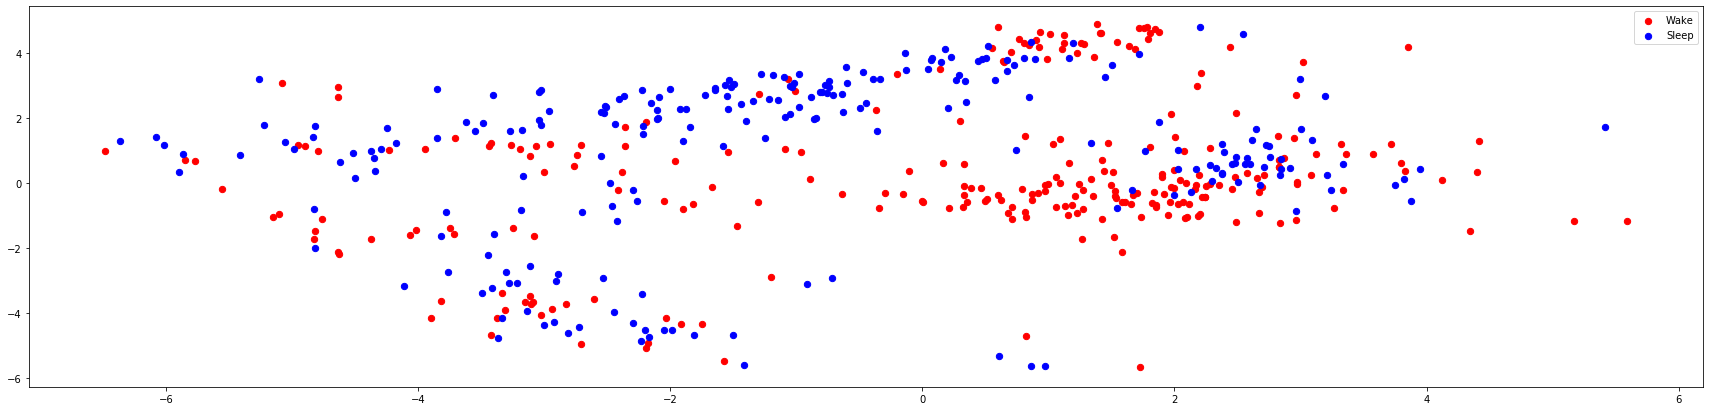

In [387]:
for treatm in obs_train["Treatment"].unique():
    subset = umap_train[obs_train["Treatment"] == treatm,:]
    x = subset[:,0]
    y = subset[:,1]
    plt.scatter(x, y, label = f"{treatm}",c=colors[treatm], s=40)
        
plt.legend()

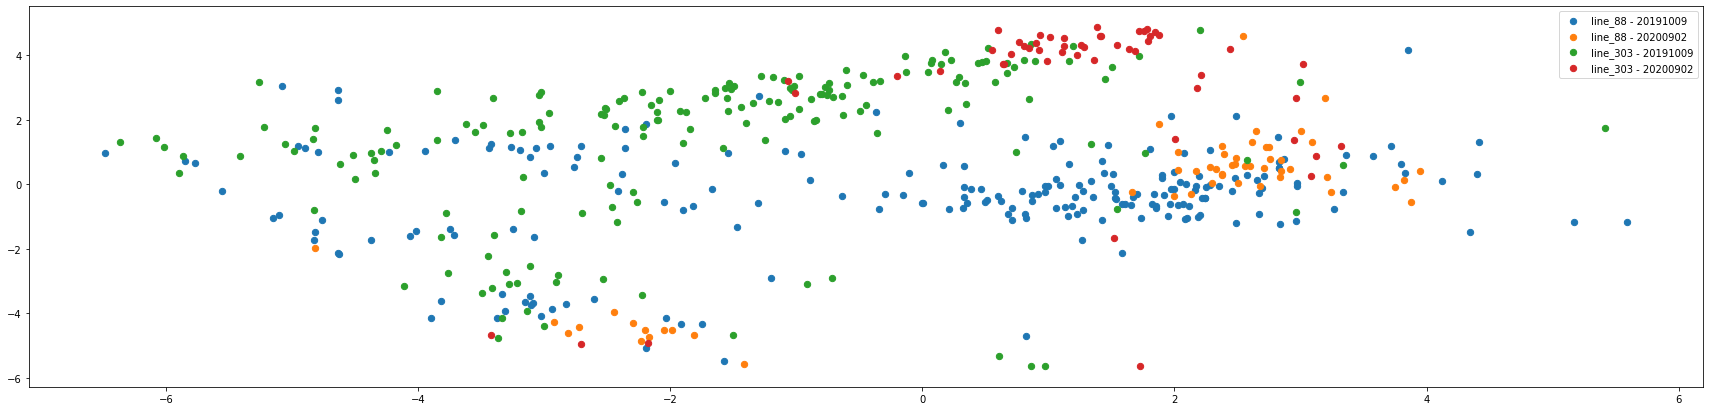

In [385]:
for dgrp_line in obs_train["Genotype"].unique():
    for run in obs_train["Run"].unique():
        subset = umap_train[np.bitwise_and(obs_train["Genotype"] == dgrp_line, obs_train["Run"] == run),:]
        x = subset[:,0]
        y = subset[:,1]
        plt.scatter(x, y, label = f"{dgrp_line} - {run}",s=40)
        
plt.legend()